# Import thư viện


In [ ]:
import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold

import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt

import pandas as pd
import pickle

In [ ]:
#Liên kết colab với google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Di chuyển đến folder chưa dataset
%cd "/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection"

/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection


In [ ]:
#Lấy data từ file train.json
train = pd.read_json('train.json')
train

,text,is_fake
0,45 rarely seen anything get noticed bff kept t...,0
1,initially passing chazchop seattle mayor jenny...,1
2,always put personal spin story sway thinkingfl...,1
3,mean talk capitalism economic system might see...,0
4,questions easily answer one joe biden stance s...,1
...,...,...
388439,official much evidence lockdowns harmful flori...,1
388440,go bankrupt two ways gradually suddenly,1
388441,career spans acting fronting two fashion busin...,0
388442,crashhackeri think picture selfsufficient repo...,1


In [ ]:
#Lấy data từ file test.json
test = pd.read_json('test.json')

# Features extraction

In [ ]:
#Bag of Words technique
countV = CountVectorizer()

In [ ]:
#TFIDF with n-grams technique
tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,2),use_idf=True,smooth_idf=True)

# K-fold cross validation

In [ ]:
#Khởi tạo hàm K-fold cross validation với đối tượng truyền vào là model
def cross_validation_train_data(classifier):
    
    #Train data được chia thành 10 folds, 9 folds để train và 1 fold còn lại để test model
    k_fold = KFold(n_splits=10)
    scores = []
    train_time = []
    test_time = []
    confusion = np.array([[0,0],[0,0]])
    
    #Dừng lại cho đến khi tất cả 10 folds trong train data đều được sử dụng để test model
    for train_ind, test_ind in k_fold.split(train):
        train_text = train.iloc[train_ind]['text'] 
        train_y = train.iloc[train_ind]['is_fake']
    
        test_text = train.iloc[test_ind]['text']
        test_y = train.iloc[test_ind]['is_fake']
        
        #Train model
        start_train_time = time.time()
        classifier.fit(train_text,train_y)
        end_train_time = time.time()
        total_train_time = end_train_time - start_train_time
        train_time.append(total_train_time)

        #Test model
        start_test_time = time.time()
        predictions = classifier.predict(test_text)
        end_test_time = time.time()
        total_test_time = end_test_time - start_test_time
        test_time.append(total_test_time)
        
        confusion += confusion_matrix(test_y,predictions)
        #Giá trị accuracy sẽ được cộng dồn tại mỗi lần test để tính giá trị accuracy trung bình
        score = accuracy_score(test_y,predictions)
        scores.append(score)
    
    return (print('Total statements classified:', len(train)),
    print('Score:', sum(scores)/len(scores)),
    print('Training time: ', sum(train_time), 'seconds'),
    print('Testing time: ', sum(test_time), 'seconds'),
    print('score length', len(scores)),
    print('Confusion matrix:'),
    print(confusion))

# Logistic Regression 

In [ ]:
#Logistic Regression - Bag of Words
logR_pipeline = Pipeline([
        ('LogRCV', countV),
        ('LogR_clf', LogisticRegression(max_iter= 1000))
        ])

In [ ]:
cross_validation_train_data(logR_pipeline)

Total statements classified: 388444
Score: 0.8615527584891615
Training time:  1624.5513825416565 seconds
Testing time:  18.328423976898193 seconds
score length 10
Confusion matrix:
[[177480  25669]
 [ 28110 157185]]


(None, None, None, None, None, None, None)

In [ ]:
#training model
start_train_time = time.time()
logR_pipeline.fit(train['text'],train['is_fake'])
end_train_time = time.time()
total_train_time = end_train_time - start_train_time

#testing model với "test data"
start_test_time = time.time()
predicted_LogR = logR_pipeline.predict(test['text'])
end_test_time = time.time()
total_test_time = end_test_time - start_test_time

Accuracy score ~ 86.35
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     50789
           1       0.86      0.85      0.86     46323

    accuracy                           0.86     97112
   macro avg       0.86      0.86      0.86     97112
weighted avg       0.86      0.86      0.86     97112

Training time:  201.15094876289368 seconds
Testing time:  4.701231002807617 seconds


0.8634978169536206

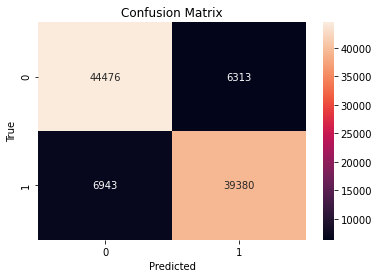

In [ ]:
#In ra giá trị accuracy và confusion matrix sau khi testing model 
score = accuracy_score(test['is_fake'], predicted_LogR)
print("Accuracy score ~", round(score * 100, 2))

print(classification_report(test['is_fake'], predicted_LogR))
print('Training time: ', total_train_time, 'seconds'),
print('Testing time: ', total_test_time, 'seconds'),

matrix = confusion_matrix(test['is_fake'], predicted_LogR)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

np.mean(predicted_LogR == test['is_fake'])

In [ ]:
#Lưu model thành file sav để có thể sử dụng mà không cần phải train lại model
filename = 'logR_pipeline.sav'
pickle.dump(logR_pipeline, open(filename, 'wb'))

In [ ]:
#Logistic Regression - tfidf-ngrams
logR_pipeline_ngram = Pipeline([
        ('LogR_tfidf', tfidf_ngram),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1, max_iter=1000))
        ])

In [ ]:
cross_validation_train_data(logR_pipeline_ngram)

Total statements classified: 388444
Score: 0.8638285055029469
Training time:  3919.6952288150787 seconds
Testing time:  48.012319803237915 seconds
score length 10
Confusion matrix:
[[182904  20245]
 [ 32650 152645]]


(None, None, None, None, None, None, None)

In [ ]:
start_train_time = time.time()
logR_pipeline_ngram.fit(train['text'],train['is_fake'])
end_train_time = time.time()
total_train_time = end_train_time - start_train_time

start_test_time = time.time()
predicted_LogR_ngram = logR_pipeline_ngram.predict(test['text'])
end_test_time = time.time()
total_test_time = end_test_time - start_test_time

Accuracy score ~ 86.67
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     50789
           1       0.88      0.83      0.86     46323

    accuracy                           0.87     97112
   macro avg       0.87      0.86      0.87     97112
weighted avg       0.87      0.87      0.87     97112

Training time:  585.3364894390106 seconds
Testing time:  11.409071683883667 seconds


0.866659115248373

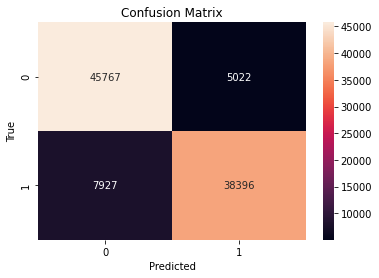

In [ ]:
score = accuracy_score(test['is_fake'], predicted_LogR_ngram)
print("Accuracy score ~", round(score * 100, 2))

print(classification_report(test['is_fake'], predicted_LogR_ngram))
print('Training time: ', total_train_time, 'seconds'),
print('Testing time: ', total_test_time, 'seconds'),

matrix = confusion_matrix(test['is_fake'], predicted_LogR_ngram)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

np.mean(predicted_LogR_ngram == test['is_fake'])

In [ ]:
#Lưu model thành file sav để có thể sử dụng mà không cần phải train lại model
filename = 'logR_pipeline_ngram.sav'
pickle.dump(logR_pipeline_ngram, open(filename, 'wb'))

# SVM

In [23]:
#SVM - Bag of Words
svm_pipeline = Pipeline([
        ('svmCV', countV),
        ('svm_clf', svm.LinearSVC(max_iter=10000))
        ])

In [24]:
cross_validation_train_data(svm_pipeline)

Total statements classified: 388444
Score: 0.8463150370060829
Training time:  4766.610652446747 seconds
Testing time:  18.959606885910034 seconds
score length 10
Confusion matrix:
[[175990  27159]
 [ 32539 152756]]


(None, None, None, None, None, None, None)

In [25]:
start_train_time = time.time()
svm_pipeline.fit(train['text'],train['is_fake'])
end_train_time = time.time()
total_train_time = end_train_time - start_train_time

start_test_time = time.time()
predicted_svm = svm_pipeline.predict(test['text'])
end_test_time = time.time()
total_test_time = end_test_time - start_test_time
#7m

Accuracy score ~ 84.79
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     50789
           1       0.85      0.82      0.84     46323

    accuracy                           0.85     97112
   macro avg       0.85      0.85      0.85     97112
weighted avg       0.85      0.85      0.85     97112

Training time:  595.7420034408569 seconds
Testing time:  4.5482494831085205 seconds


0.8479281654172501

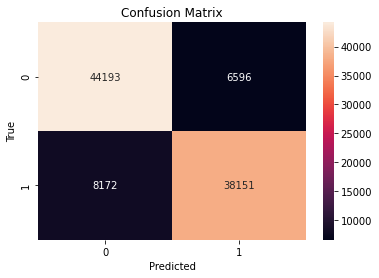

In [26]:
score = accuracy_score(test['is_fake'], predicted_svm)
print("Accuracy score ~", round(score * 100, 2))

print(classification_report(test['is_fake'], predicted_svm))
print('Training time: ', total_train_time, 'seconds'),
print('Testing time: ', total_test_time, 'seconds'),

matrix = confusion_matrix(test['is_fake'], predicted_svm)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

np.mean(predicted_svm == test['is_fake'])


In [ ]:
#Lưu model thành file sav để có thể sử dụng mà không cần phải train lại model
filename = 'svm_pipeline.sav'
pickle.dump(svm_pipeline, open(filename, 'wb'))

In [ ]:
#SVM - tfidf-ngrams
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf', tfidf_ngram),
        ('svm_clf',svm.LinearSVC())
        ])

In [ ]:
cross_validation_train_data(svm_pipeline_ngram)

Total statements classified: 388444
Score: 0.8826008326834207
Training time:  1270.4354581832886 seconds
Testing time:  57.900699615478516 seconds
score length 10
Confusion matrix:
[[185718  17431]
 [ 28172 157123]]


(None, None, None, None, None, None, None)

In [ ]:
start_train_time = time.time()
svm_pipeline_ngram.fit(train['text'],train['is_fake'])
end_train_time = time.time()
total_train_time = end_train_time - start_train_time

start_test_time = time.time()
predicted_svm_ngram = svm_pipeline_ngram.predict(test['text'])
end_test_time = time.time()
total_test_time = end_test_time - start_test_time

Accuracy score ~ 87.63
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     50789
           1       0.88      0.86      0.87     46323

    accuracy                           0.88     97112
   macro avg       0.88      0.88      0.88     97112
weighted avg       0.88      0.88      0.88     97112

Training time:  114.19461584091187 seconds
Testing time:  13.580870389938354 seconds


0.8762562814070352

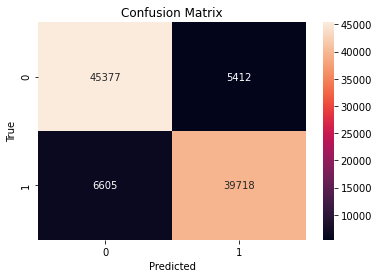

In [ ]:
score = accuracy_score(test['is_fake'], predicted_svm_ngram)
print("Accuracy score ~", round(score * 100, 2))

print(classification_report(test['is_fake'], predicted_svm_ngram))
print('Training time: ', total_train_time, 'seconds'),
print('Testing time: ', total_test_time, 'seconds'),

matrix = confusion_matrix(test['is_fake'], predicted_svm_ngram)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

np.mean(predicted_svm_ngram == test['is_fake'])

# Naive Bayes


In [ ]:
#naive bayes - Bag of Words
nb_pipeline = Pipeline([
        ('NBCV', countV),
        ('nb_clf',MultinomialNB())])

In [ ]:
cross_validation_train_data(nb_pipeline)

Total statements classified: 388444
Score: 0.8361308212940278
Training time:  178.5993254184723 seconds
Testing time:  18.22676181793213 seconds
score length 10
Confusion matrix:
[[175578  27571]
 [ 36083 149212]]


(None, None, None, None, None, None, None)

In [ ]:
start_train_time = time.time()
nb_pipeline.fit(train['text'],train['is_fake'])
end_train_time = time.time()
total_train_time = end_train_time - start_train_time

start_test_time = time.time()
predicted_nb = nb_pipeline.predict(test['text'])
end_test_time = time.time()
total_test_time = end_test_time - start_test_time

Accuracy score ~ 83.53
              precision    recall  f1-score   support

           0       0.83      0.86      0.85     50789
           1       0.84      0.80      0.82     46323

    accuracy                           0.84     97112
   macro avg       0.84      0.83      0.83     97112
weighted avg       0.84      0.84      0.84     97112

Training time:  19.117652416229248 seconds
Testing time:  4.490044116973877 seconds


0.8352932696268226

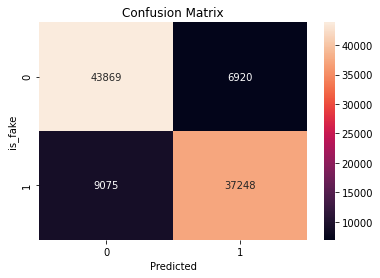

In [ ]:
score = accuracy_score(test['is_fake'], predicted_nb)
print("Accuracy score ~", round(score * 100, 2))

print(classification_report(test['is_fake'], predicted_nb))
print('Training time: ', total_train_time, 'seconds'),
print('Testing time: ', total_test_time, 'seconds'),

matrix = confusion_matrix(test['is_fake'], predicted_nb)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('is_fake')

np.mean(predicted_nb == test['is_fake'])

In [ ]:
#Lưu model thành file sav để có thể sử dụng mà không cần phải train lại model
filename = 'nb_pipeline.sav'
pickle.dump(nb_pipeline, open(filename, 'wb'))

In [ ]:
#naive bayes - tfidf-ngrams
nb_pipeline_ngram = Pipeline([
        ('nb_tfidf',tfidf_ngram),
        ('nb_clf',MultinomialNB())])

In [ ]:
cross_validation_train_data(nb_pipeline_ngram)

Total statements classified: 388444
Score: 0.8394079926082074
Training time:  1039.5265493392944 seconds
Testing time:  57.68834185600281 seconds
score length 10
Confusion matrix:
[[187627  15522]
 [ 46859 138436]]


(None, None, None, None, None, None, None)

In [20]:
start_train_time = time.time()
nb_pipeline_ngram.fit(train['text'],train['is_fake'])
end_train_time = time.time()
total_train_time = end_train_time - start_train_time

start_test_time = time.time()
predicted_nb_ngram = nb_pipeline_ngram.predict(test['text'])
end_test_time = time.time()
total_test_time = end_test_time - start_test_time

Accuracy score ~ 84.1
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     50789
           1       0.90      0.75      0.82     46323

    accuracy                           0.84     97112
   macro avg       0.85      0.84      0.84     97112
weighted avg       0.85      0.84      0.84     97112

Training time:  117.82983660697937 seconds
Testing time:  14.542934656143188 seconds


0.8410186176785567

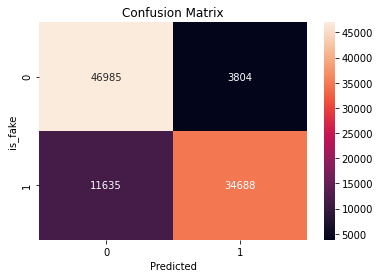

In [21]:
score = accuracy_score(test['is_fake'], predicted_nb_ngram)
print("Accuracy score ~", round(score * 100, 2))

print(classification_report(test['is_fake'], predicted_nb_ngram))
print('Training time: ', total_train_time, 'seconds'),
print('Testing time: ', total_test_time, 'seconds'),

matrix = confusion_matrix(test['is_fake'], predicted_nb_ngram)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('is_fake')

np.mean(predicted_nb_ngram == test['is_fake'])

In [22]:
#Lưu model thành file sav để có thể sử dụng mà không cần phải train lại model
filename = 'nb_pipeline_ngram.sav'
pickle.dump(nb_pipeline_ngram, open(filename, 'wb'))

Ta thấy rằng model **Linear SVM** với **tfidf-ngrams** đưa ra được kết quả tốt nhất 

# Dùng model tốt nhất ở trên (Linear SVM - TFIDF - ngrams) để dự đoán input do người dùng nhập vào

In [ ]:
#Lưu model thành file sav để có thể sử dụng mà không cần phải train lại model
filename = 'final_model.sav'
pickle.dump(svm_pipeline_ngram, open(filename, 'wb'))

In [ ]:
#Đưa vào một đoạn text muốn kiểm chứng là tin thật hay giả
#Output sẽ trả về kết quả dự đoán về đoạn text đó
doc = input("Enter news: ")

filename = 'final_model.sav'

final_model = pickle.load(open(filename, 'rb'))

pre = final_model.predict([doc])
label = "Fake" if pre[0] == 1 else "Real"
print("\nThe give text is", label, "news")

Enter news: But people with the virus can test positive for many days. Think of it like filling a bath with the plughole open. Incidence is how quickly water flows in, the positivity is the level of the water in the bath, and there is some draining as older infections fall away. As you start turning the taps down, the level continues to rise for a while longer, until the plughole takes over.  This is demonstrated in Scotland, which has been ahead of England both in starting school holidays and getting knocked out of Euro 2020. Its confirmed cases hit a peak at the end of June and central ONS positivity estimates and hospitalisations are now declining. This is all good, and somewhat unexpected, news.  Other recent survey findings include that 40% of infections show no symptoms - a bit higher than the “one in three” figure usually quoted. And for those unlucky enough to get reinfected, at least the second infection tends to be milder. In contrast, the US struggles without a nationwide su